In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import default_collate

torch.backends.quantized.engine = 'qnnpack'

def activation(x):
    beta = 5
    return 2 * torch.sigmoid(beta * x) * (1 + beta * torch.sigmoid(beta * x)) - 1

class BNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(BNN, self).__init__()
        kernel_size_1 = 16
        kernel_size_2 = 29 - kernel_size_1
        intermediate_size = hidden_size
        self.fc1 = nn.Linear(768, intermediate_size, bias=False)
        self.clip1 = nn.Hardtanh(-1, 1)
        self.fc2 = nn.Linear(intermediate_size, 10, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.clip1(x)
        x = self.fc2(x)
        x = x.view(-1, 10)
        return x

def train(model, trainloader, weight_decay=0.0000):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            inputs = inputs.view(-1, 1, 28 * 28)
            inputs = inputs[:, :, :768]
            labels = labels.to(device)
            outputs = model(inputs)
            labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
        accuracy = test_normal(model, testloader)
        accuracy_list.append(accuracy)
        print()
    return accuracy_list

def test_normal(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 1, 28 * 28)
            inputs = inputs[:, :, :768]
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network unrounded on the 10000 test images: {accuracy} %')
    return accuracy

if __name__ == '__main__':
    training = True
    device = "cpu"
    batch_size = 2000
    test_batch_size = 20
    num_epochs = 50
    learning_rate = 0.0005
    weight_decay = 0.0000

    hidden_sizes = [32, 64, 96, 128, 256]
    results = []

    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: np.where(x > 0, 1, -1).astype(np.float32)), transforms.Lambda(lambda x: x[:768])])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

    if training:
        for hidden_size in hidden_sizes:
            print(f'Training with hidden_size={hidden_size}')
            model = BNN(hidden_size=hidden_size)
            accuracy_list = train(model, trainloader, weight_decay=weight_decay)
            torch.save(model.state_dict(), f'bnn_model_{hidden_size}.pth')
            results.append((hidden_size, accuracy_list))
    else:
        model = BNN(hidden_size=hidden_size)
        model.load_state_dict(torch.load(f'bnn_model_{hidden_size}.pth'))
        model.eval()
        test_normal(model, testloader)

Training with hidden_size=32
Epoch 1, Loss: 1.6390082120895386
Accuracy of the network unrounded on the 10000 test images: 77.63 %

Epoch 2, Loss: 1.0471758762995402
Accuracy of the network unrounded on the 10000 test images: 84.68 %

Epoch 3, Loss: 0.8205566823482513
Accuracy of the network unrounded on the 10000 test images: 87.0 %

Epoch 4, Loss: 0.6854485134283702
Accuracy of the network unrounded on the 10000 test images: 88.46 %

Epoch 5, Loss: 0.594746736685435
Accuracy of the network unrounded on the 10000 test images: 89.28 %

Epoch 6, Loss: 0.5293949236472447
Accuracy of the network unrounded on the 10000 test images: 89.86 %

Epoch 7, Loss: 0.4809887081384659
Accuracy of the network unrounded on the 10000 test images: 90.07 %

Epoch 8, Loss: 0.4438207745552063
Accuracy of the network unrounded on the 10000 test images: 90.51 %

Epoch 9, Loss: 0.41429527997970583
Accuracy of the network unrounded on the 10000 test images: 90.83 %

Epoch 10, Loss: 0.39019033511479695
Accuracy 

In [2]:
print(results)

[(32, [77.63, 84.68, 87.0, 88.46, 89.28, 89.86, 90.07, 90.51, 90.83, 91.16, 91.29, 91.52, 91.64, 91.8, 92.03, 92.16, 92.26, 92.41, 92.52, 92.49, 92.72, 92.76, 92.56, 93.01, 92.74, 93.13, 93.14, 93.22, 93.31, 93.27, 93.44, 93.52, 93.46, 93.52, 93.52, 93.69, 93.7, 93.75, 93.65, 93.62, 93.79, 93.77, 93.92, 93.97, 93.83, 94.01, 93.94, 94.07, 93.98, 94.16]), (64, [82.69, 87.73, 89.08, 89.91, 90.5, 90.98, 91.36, 91.69, 92.07, 92.2, 92.47, 92.73, 92.82, 93.11, 93.11, 93.37, 93.66, 93.66, 93.92, 93.94, 94.05, 94.18, 94.32, 94.29, 94.33, 94.47, 94.56, 94.62, 94.79, 94.7, 94.67, 94.83, 94.89, 94.87, 95.03, 95.15, 95.0, 95.17, 95.16, 95.29, 95.43, 95.31, 95.4, 95.38, 95.48, 95.48, 95.46, 95.58, 95.56, 95.66]), (96, [84.52, 88.75, 89.88, 90.71, 91.41, 91.6, 92.19, 92.43, 92.87, 93.13, 93.23, 93.31, 93.64, 93.8, 93.95, 94.13, 94.19, 94.47, 94.76, 94.88, 94.92, 94.98, 95.04, 95.08, 95.53, 95.48, 95.52, 95.6, 95.67, 95.73, 95.84, 95.98, 95.94, 95.78, 96.14, 95.95, 96.07, 96.07, 96.02, 96.2, 96.39, 96

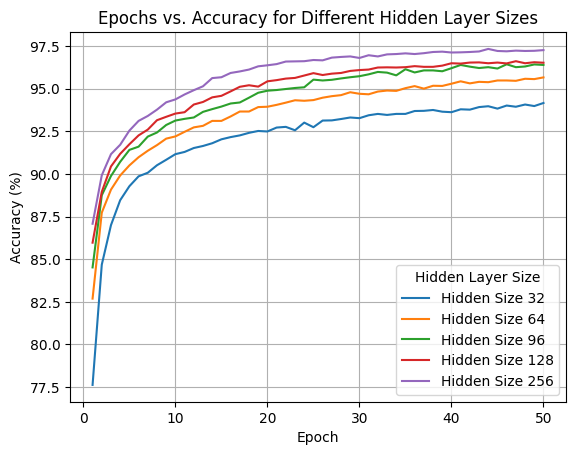

In [4]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure()
for hidden_size, accuracies in results:
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Hidden Size {hidden_size}')

plt.title('Epochs vs. Accuracy for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(title='Hidden Layer Size')
plt.grid(True)
plt.show()